<a href="https://colab.research.google.com/github/linyuehzzz/5523_project/blob/main/sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Stochastic Gradient Descent for Logistic Regression**
This code implements and tests the SGD algorithm for logistic regression
in different scenarios.  
Yifei Zhang (zhang.5387 at osu edu), Yue Lin (lin.3326 at osu.edu)  
Created: 11/12/2020

#### **Set up libraries**

In [45]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

#### **Project**

##### Projection function for hypercube

In [46]:
def cube_prj(sample):
    '''
    This function projects both domain and parameter sets to a hypercube.

    sample: features or gradients, 1*d array (d: #dimension)

    return: 
        the projected vector onto a hypercube with edge length 2 and centered around the origin
    '''
    return [np.sign(i) * min(np.abs(i), 1) for i in sample]

##### Projection function for unit ball

In [47]:
def ball_prj(sample):
    '''
    This function projects both domain and parameter sets to a unit ball.

    sample: features or gradients, 1*d array (d: #dimension)

    return: 
        the projected vector onto a unit ball centered around the origin
    '''
    if np.linalg.norm(sample, ord=2) > 1:
        return sample / np.linalg.norm(sample, ord=2)
    else:
        return sample

##### Project data

In [48]:
def prj_data(x, y, prj_code):
    '''
    This function projects the domain set in terms for two scenarios.

    X: feature vectors, n*d array (n: #sample, d: #dimension)
    y: labels, 1*n array with values of -1 or +1
    prj_code: type of projection, 0 for cube, 1 for ball

    return:
        prj_x: projected feature vectors 
        y: labels, same as the input
    '''
    if prj_code == 0:
        prj_x = np.apply_along_axis(cube_prj, 1, x)
    elif prj_code == 1:
        prj_x = np.apply_along_axis(ball_prj, 1, x)
    else:
        print("Please input correct code for projection type: 0 for cube, 1 for ball")
      
    b = np.ones((prj_x.shape[0], 1))
    prj_x = np.append(prj_x, b, axis=1)
    return prj_x, y

##### Project gradient

In [49]:
def prj_grad(g, prj_code):
    '''
    This function projects the parameter set for two scenarios.

    g: gradients, 1*d array (d: #dimension)
    prj_code: type of projection, 0 for cube, 1 for ball

    return:
        prj_g: projected gradients
    '''
    if prj_code == 0:
        prj_g = cube_prj(g)
    elif prj_code == 1:
        prj_g = ball_prj(g)
    else:
        print("Please input correct code for projection type: 0 for cube, 1 for ball")
    return prj_g

#### **Prepare data**

In [50]:
def gen_data(sig, n, d_dimension):
    '''
    This function generates the data for training and test.

    sig: standard deviation of the Gaussian function
    n: number of samples
    d_dimension: dimensionality of the feature vectors
    
    Return:
        X: feature vectors, n*d array (n: #sample, d: #dimension)
        y: labels, 1*n array with values of -1 and +1
    '''
    # d_dimension = 4
    y = np.random.choice([-1, 1], p = [0.5, 0.5], size = n)
    x = np.array([])
    for i in range(n):
        if y[i] == -1:
            mu = -(1 / 4)
            negvec = np.random.normal(mu, sig, d_dimension)
            x = np.concatenate([x, negvec], axis=0)
        else:
            mu = (1 / 4)
            posvec = np.random.normal(mu, sig, d_dimension)
            x = np.concatenate([x, posvec], axis=0)
    x = np.reshape(x, (n, d_dimension))
    return x, y

#### **Train**
https://machinelearningmastery.com/implement-logistic-regression-stochastic-gradient-descent-scratch-python/

##### Estimate logistic loss

In [51]:
def log_loss(X, y, w):
    '''
    This function outputs the logistic loss.

    X: feature vector, 1*d array (d: #dimension)
    y: label
    w: weight vector, 1*d array
    
    Return: logistic loss
    '''
    return np.log(1 + np.exp(-y * np.dot(w.T, X)))

##### Estimate classification error

In [52]:
def err(X, y, w):
    '''
    This function outputs the classification error.

    X: feature vector, 1*d array (d: #dimension)
    y: label
    w: weight vector, 1*d array
    
    Return: classification error
    '''
    return 0 if np.sign(np.dot(w.T, X)) == y else 1

##### SGD

In [53]:
def sdg(train_x, train_y):
    '''
    train_x: feature vectors one batch
    train_y: lables in one batch
    return: 
            w: weight vector trained on one batch
    '''
    w_all = []
    w_t = np.zeros(train_x.shape[1])
    for idx in range(train_x.shape[0]):
        # Read data
        X = train_x[idx]
        y = train_y[idx]
        w_t = np.array(w_t)
        # Calculate gradient
        g = (-y * X * np.exp(-y * np.dot(w_t.T, X)) / (1 + np.exp(-y * np.dot(w_t.T, X))))
        # Project gradient
        w_t = prj_grad(np.add(w_t, np.multiply(-l_rate, g)), prj_code)
        # Backward propagation
        w_all.append(w_t)
    return np.average(np.array(w_all), axis=0)

##### Estimate weight vector using SGD

In [54]:
def train(train_x, train_y, test_x, test_y, l_rate, n_epoch, bs, prj_code):
    '''
    This function implements and tests the SGD algorithm for logistic regression.

    train_x: feature vectors for training, n*d array (n: #sample, d: #dimension)
    train_y: labels for training, 1*n array
    test_x: feature vectors for test, n*d array (n: #sample, d: #dimension)
    test_y: labels for test, 1*n array
    l_rate: learning rate
    n_epoch: number of trials
    bs: training set size
    prj_code: type of projection, 0 for cube, 1 for ball
    
    Return: 
        w: final weights
        risk_ave: average risk
        risk_min: minimum of all risks
        risk_var: standard deviation of all risks
        exp_excess_risk: expected excess risk
        cls_err_ave: average classification error
        cls_err_var: standard deviation of all classification errors
    '''
    risk_all = []
    cls_err_all = []

    for epoch in range(n_epoch):
        risk = cls_err = 0.
        train_x0 = train_x[epoch * bs: (epoch + 1) * bs] ## use current batch to for trainning
        train_y0 = train_y[epoch * bs: (epoch + 1) * bs] ## use current batch to for trainning
        w = sdg(train_x0, train_y0)
    
        # Evaluate
        for idx in range(test_x.shape[0]):
            # Read data
            X = test_x[idx]
            y = test_y[idx]
            # Evaluate
            risk += log_loss(X, y, w) / test_x.shape[0]
            cls_err += err(X, y, w) / test_x.shape[0]
    
        risk_all = np.append(risk_all, risk)
        cls_err_all = np.append(cls_err_all, cls_err)
        # print('>epoch=%d, lrate=%.3f, risk=%.3f, classification error=%.3f' % (epoch, l_rate, risk, cls_err))
  
    # Report risk
    # print(risk_all, cls_err_all)
    risk_ave = np.average(risk_all)
    risk_min = np.amin(risk_all)
    risk_var = np.sqrt(np.var(risk_all))
    exp_excess_risk = risk_ave - risk_min
    # Report classification error
    cls_err_ave = np.average(cls_err_all)
    cls_err_var = np.sqrt(np.var(cls_err_all))
    return [w, risk_ave, risk_min, risk_var, exp_excess_risk, cls_err_ave, cls_err_var]

#### **Wrapper test**

##### Generate data and train

In [55]:
# Fixed hyperparameters
n_epoch = 30    # training epochs
test_n = 400    # size of test set

# Unfixed hyperparameters
prj_code = 1    # code for two scenario: 0 for cube, 1 for ball
l_rate = 0.16  # learning rate: 0.04 for cube, 0.18 for ball
train_bs = np.array([50, 100, 500, 1000])   # batch size for each training epoch
sigma = 0.1     # variance of Gaussian distribution
d_dimension = 4

np.random.seed(0)

excess_risk = []
cls_error = []
excess_risk_var = []
cls_error_var = []

for bs in train_bs:
    # Generate training data
    train_x, train_y = gen_data(sigma, bs * n_epoch, d_dimension)
    train_px, train_py = prj_data(train_x, train_y, prj_code)

    # Generate test data
    test_x, test_y = gen_data(sigma, test_n, d_dimension)
    test_px, test_py = prj_data(test_x, test_y, prj_code)

    # Train
    output = train(train_px, train_py, test_px, test_py, l_rate, n_epoch, bs, prj_code)
    print(output)
    print('>scenario=%d, sigma=%.2f, n=%d, log_loss_mean=%.3f, log_loss_std_dev=%.3f, log_loss_min=%.3f, \
            excess_risk=%.3f, cls_error_mean=%.3f, cls_error_std_dev=%.3f' 
            % (prj_code+1, sigma, bs, output[1], output[3], output[2], output[4], output[5], output[6]))
    
    excess_risk = np.append(excess_risk, output[4], axis=None)
    cls_error = np.append(cls_error, output[5],  axis=None)
    excess_risk_var = np.append(excess_risk_var, output[3], axis=None)
    cls_error_var = np.append(cls_error_var, output[6],  axis=None)

[array([0.3744133 , 0.3927996 , 0.35683688, 0.34664222, 0.20370563]), 0.5335345339521229, 0.5243968290592895, 0.006107054255037317, 0.009137704892833387, 0.014916666666666668, 0.026319220902011692]
>scenario=2, sigma=0.10, n=50, log_loss_mean=0.534, log_loss_std_dev=0.006, log_loss_min=0.524,             excess_risk=0.009, cls_error_mean=0.015, cls_error_std_dev=0.026
[array([ 0.42616915,  0.42959132,  0.43580235,  0.43469545, -0.09872164]), 0.5050671923945232, 0.5017356815809559, 0.003017145106202241, 0.0033315108135673066, 0.0003333333333333333, 0.001404358295529393]
>scenario=2, sigma=0.10, n=100, log_loss_mean=0.505, log_loss_std_dev=0.003, log_loss_min=0.502,             excess_risk=0.003, cls_error_mean=0.000, cls_error_std_dev=0.001
[array([ 0.48499799,  0.47776798,  0.47003138,  0.4878303 , -0.02222235]), 0.48267224632236405, 0.4804573593373066, 0.0014069399847521154, 0.0022148869850574515, 0.0, 0.0]
>scenario=2, sigma=0.10, n=500, log_loss_mean=0.483, log_loss_std_dev=0.001, l

##### Plot excess risk

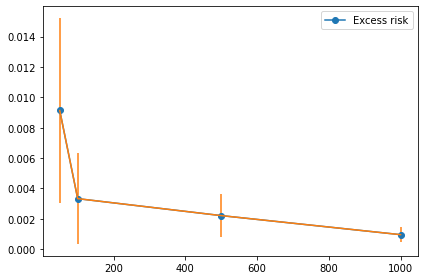

In [56]:
plt.plot(train_bs, excess_risk, '-o', label='Excess risk')
plt.errorbar(train_bs, excess_risk, excess_risk_var)
plt.legend()
plt.tight_layout()
plt.show()

##### Plot classification error

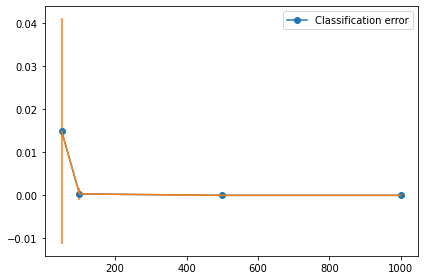

In [57]:
plt.plot(train_bs, cls_error, '-o', label='Classification error')
plt.errorbar(train_bs, cls_error, cls_error_var)
plt.legend()
plt.tight_layout()
plt.show()

#### **Wrapper**

In [58]:
# Set up hyperparameters
n_epoch = 30    # training epochs
test_n = 400    # size of test set
d_dimension = 4
train_bs = np.array([50, 100, 500, 1000])  # batch size for each training epoch

np.random.seed(3)

##### Run all experiments

In [59]:
result_list = []
for prj_code in [0, 1]:
    for sigma in [0.1, 0.35]:
        for bs in train_bs:

            if prj_code == 0:
                rho = np.sqrt(d_dimension + 1)
                m = 2 * np.sqrt(d_dimension + 1)
            else:
                rho = np.sqrt(2)
                m = 2
            
            l_rate = m / (rho * np.sqrt(bs))

            # Generate training data
            train_x, train_y = gen_data(sigma, bs * n_epoch, d_dimension)
            train_px, train_py = prj_data(train_x, train_y, prj_code)

            # Generate test data
            test_x, test_y = gen_data(sigma, test_n, d_dimension)
            test_px, test_py = prj_data(test_x, test_y, prj_code)

            # Train
            output = train(train_px, train_py, test_px, test_py, l_rate, n_epoch, bs, prj_code)

            print(output)
            print('>scenario=%d, sigma=%.2f, n=%d, lr=%.2f, log_loss_mean=%.3f, log_loss_std_dev=%.3f, log_loss_min=%.3f, \
                excess_risk=%.3f, cls_error_mean=%.3f, cls_error_std_dev=%.3f' 
                % (prj_code+1, sigma, bs, l_rate, output[1], output[3], output[2], output[4], output[5], output[6]))
            result = [prj_code + 1, sigma, bs, n_epoch,output[1], output[3], output[2], output[4], output[5], output[6]]
            result_list.append(result)

[array([ 0.67547051,  0.6758275 ,  0.65342979,  0.66033909, -0.11939478]), 0.4222767948915829, 0.411645021105253, 0.010351662389670294, 0.010631773786329901, 0.005166666666666668, 0.023987265139838034]
>scenario=1, sigma=0.10, n=50, lr=0.28, log_loss_mean=0.422, log_loss_std_dev=0.010, log_loss_min=0.412,                 excess_risk=0.011, cls_error_mean=0.005, cls_error_std_dev=0.024
[array([0.77445133, 0.78500146, 0.70571113, 0.78316496, 0.00525608]), 0.3849366578114302, 0.3786385794830568, 0.003894441748600809, 0.006298078328373424, 0.0, 0.0]
>scenario=1, sigma=0.10, n=100, lr=0.20, log_loss_mean=0.385, log_loss_std_dev=0.004, log_loss_min=0.379,                 excess_risk=0.006, cls_error_mean=0.000, cls_error_std_dev=0.000
[array([ 0.89551235,  0.88866145,  0.89292803,  0.89159092, -0.028138  ]), 0.3499273608999994, 0.348222461281334, 0.0009981842923834315, 0.0017048996186653786, 0.0, 0.0]
>scenario=1, sigma=0.10, n=500, lr=0.09, log_loss_mean=0.350, log_loss_std_dev=0.001, log_l

##### Plot table

In [60]:
column_name = ["Scenario", "sigma", "N", "#trails", "Loss_Mean", "Loss_StdDev", "Loss_Min", "Loss_ExcessRisk",
             "Error_Mean", "Error_StdDev"]
result_df = pd.DataFrame(result_list, columns = column_name)
result_df

,Scenario,sigma,N,#trails,Loss_Mean,Loss_StdDev,Loss_Min,Loss_ExcessRisk,Error_Mean,Error_StdDev
0,1,0.10,50,30,0.422277,0.010352,0.411645,0.010632,0.005167,0.023987
1,1,0.10,100,30,0.384937,0.003894,0.378639,0.006298,0.000000,0.000000
2,1,0.10,500,30,0.349927,0.000998,0.348222,0.001705,0.000000,0.000000
3,1,0.10,1000,30,0.334924,0.000884,0.333487,0.001437,0.000000,0.000000
4,1,0.35,50,30,0.469225,0.014753,0.440774,0.028450,0.114500,0.025028
5,1,0.35,100,30,0.424214,0.006871,0.404873,0.019341,0.081917,0.005578
6,1,0.35,500,30,0.394387,0.002106,0.388598,0.005790,0.074917,0.004978
7,1,0.35,1000,30,0.395125,0.001107,0.393135,0.001990,0.097750,0.001750
8,2,0.10,50,30,0.522967,0.007392,0.513849,0.009118,0.010167,0.023909
9,2,0.10,100,30,0.508059,0.003043,0.504533,0.003526,0.000167,0.000624


##### Plot grid

In [61]:
def plot_result(estimator, result_df):
    '''
    estimator: 
        0 is for ["Loss_ExcessRisk", "Loss_StdDev"]
        1 is for ["Error_Mean", "Error_StdDev"]
    result_df:
        result table above
    
    '''
    labels = {0: "Excess Risk", 1: "Error"}
    if estimator == 0:
        col = ["Loss_ExcessRisk", "Loss_StdDev"]
    else:
        col = ["Error_Mean", "Error_StdDev"]
        
    fig = plt.figure(figsize = (16, 10))
    index = 0
    for senario in [1, 2]:
        for sigma in [0.1, 0.35]:
            index += 1
            plt.subplot(2, 2, index)
            df = result_df[np.logical_and(result_df["Scenario"] == senario, result_df["sigma"] == sigma)]
            excess_risk, excess_risk_var = df[col[0]], df[col[1]]

            plt.plot(train_bs, excess_risk, 'D', label = col[0])
            plt.errorbar(train_bs, excess_risk, excess_risk_var, ecolor="black", ls="--")

            plt.xlabel("n", fontsize = 12)
            plt.xticks(fontsize = 12)
            plt.ylabel(labels[estimator], fontsize = 12)
            plt.yticks(fontsize = 12)
            plt.title("Scenario " + str(senario) + ", Sigma=" + str(sigma), fontsize=15) 
    fig.legend(col, loc = "upper right", fontsize=13)
    plt.tight_layout()
    plt.show()

###### Plot excess risk

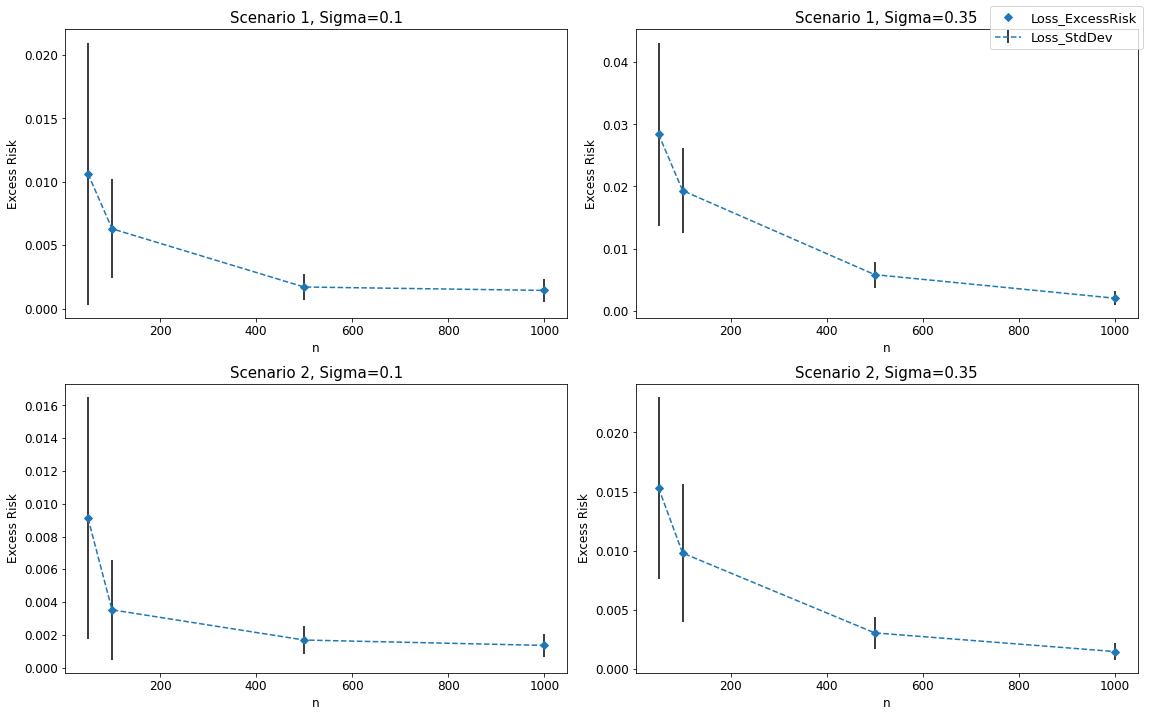

In [62]:
plot_result(0, result_df)

###### Plot classification error

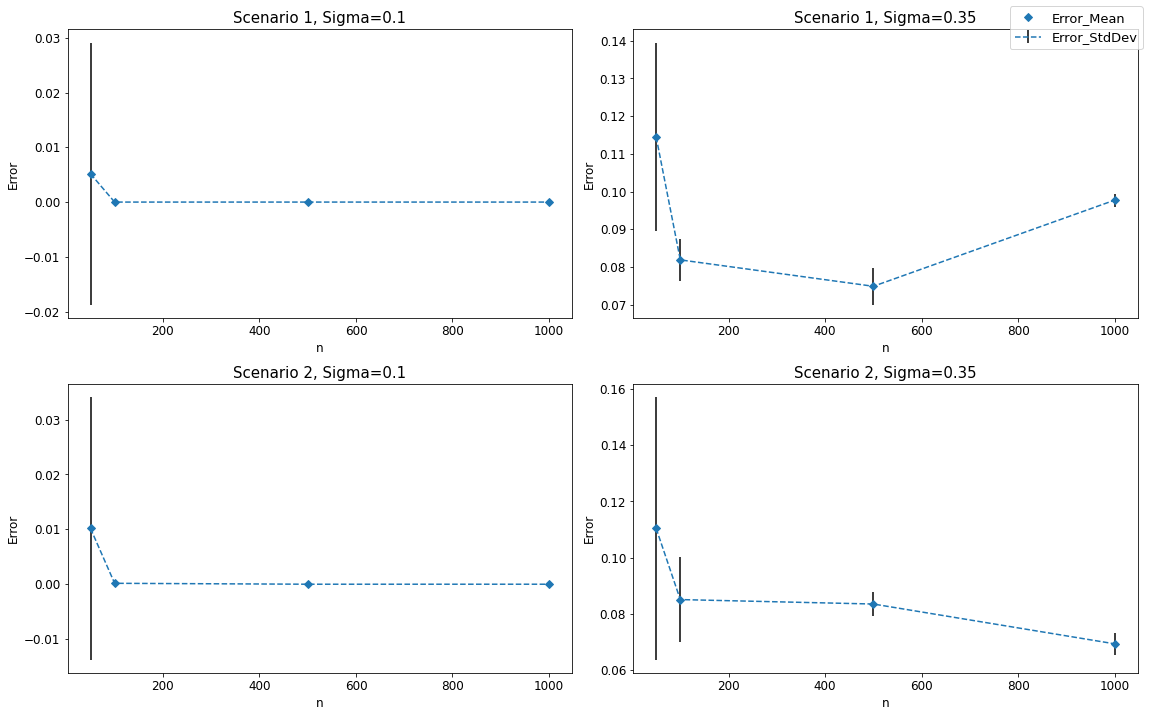

In [63]:
plot_result(1, result_df)